## Rank-Sparsity 

In the first part of this repository, I implement ADMM for the problem of separating a background image from foreground interference. The dataset can be downloaded at: http://www.svcl.ucsd.edu/projects/background_subtraction/JPEGS.tar.gz 

We will solve the below problem:

$$
\begin{align*}
\mbox{minimize} & \ \|L\|_* + \gamma \|M\|_1 \\
\mbox{subj. to:} & \ L+M=A
\end{align*}
$$

where $\gamma>0$ is a parameter that you will have to tune. 

I use only the first dataset, birds, which contains 71 jpeg images each with 37752 gray-scale pixels. Form a matrix A of size 37752 x 71 with these images. 

Note that this algorithm requires SVD. Computing the SVD in the usual way is very expensive for this dataset because the U matrix in SVD has size 37752 × 37752. You will have to utilize the "economy" SVD in https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.svd.html
or 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html
by setting the option full_matrices = False.

In [2]:
import cv2
import glob
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import sys
from scipy import linalg
import scipy

import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

X_data = []
A = []
count = 0
files = sorted(glob.glob("../birds/*.jpg"), key=numericalSort)
for image in files:
    read_im = np.array(cv2.imread(image))
    height,width = read_im.shape[0],read_im.shape[1]

    read_im = read_im.transpose(2,0,1).reshape(3,-1)
    read_im = read_im[0][:]
    
    A.append(read_im)
    if count < 70:
        X_data.append(read_im)
        count = count + 1
    else:
        print(count)
        print(image)
        Y_target = read_im
    
A = np.array(A).T
print('A shape:', np.array(A).shape)

X_data = np.array(X_data).T
print('X_data shape:', np.array(X_data).shape)

Y_target = np.array(Y_target).T
print('Y_target shape:', np.array(Y_target).shape)

70
/home/aa2deshm/Desktop/Waterloo/Fall 2019/Optimization_for_DS/A6/birds/frame_71.jpg
A shape: (37752, 71)
X_data shape: (37752, 70)
Y_target shape: (37752,)


In [3]:
def prox_nuclear_l(x, p):
    u, s, v = linalg.svd(x,full_matrices=False)
    condn = 1/p
    term = np.where(s >= condn, s - condn, 0)
    size = len(term)
    term = scipy.linalg.diagsvd(term,size,size)
    prox = (u.dot(term)).dot(v)
    return prox

def prox_l1_m(u, p, gamma):
    condn = gamma/p
    term = np.where(u >= condn, u - condn, u)
    term = np.where(np.absolute(u) <= condn, 0, term)
    prox = np.where(u <= -condn, u + condn, term)
    return prox

def ADMM_ranksparsity(A, p, m, y, max_iter, gamma, eps):
    iteration = 0
    while iteration < max_iter:
        send_l = A - m - y/p
        l = prox_nuclear_l(send_l, p)
        
        send_m = A - l - y/p
        m = prox_l1_m(send_m, p, gamma)
        
        y = y + p*(l + m - A)
        
        termination_condn = norm(l + m - A, 2)
        if termination_condn < eps: 
            break
        iteration = iteration + 1
    return l, m

In [21]:
max_iter = 50
p = 1
gamma = 0.0001
eps = 1e-9

m = np.zeros(A.shape)
y = np.zeros(A.shape)    
l_opt, m_opt = ADMM_ranksparsity(A, p, m, y, max_iter, gamma, eps)

Picture number:  1


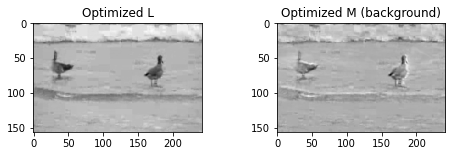

Picture number:  11


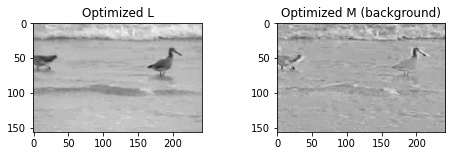

Picture number:  21


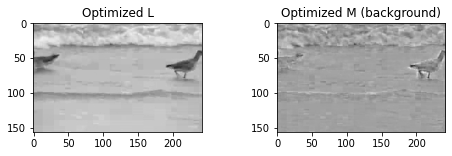

Picture number:  31


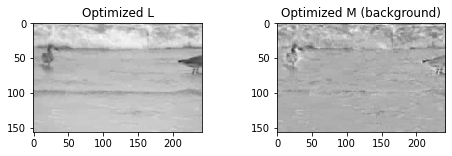

Picture number:  41


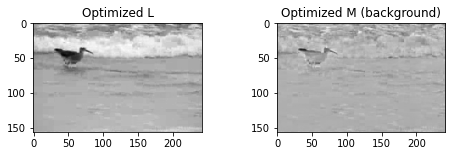

Picture number:  51


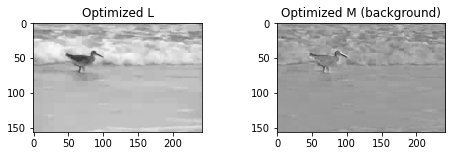

Picture number:  61


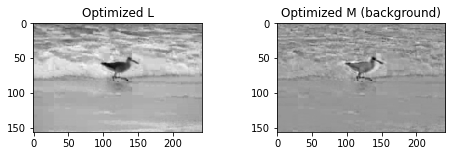

Picture number:  71


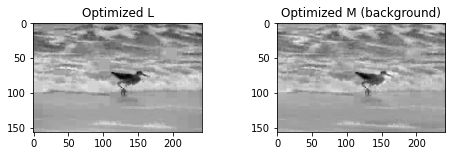

In [24]:
def show_images(l, m, num, height, width):
    plt.figure(figsize= (8,2))
    plt.subplot(1,2,1)
    im_vec1 = l_opt[:, num]
    image1 = im_vec1.reshape((height, width))
    plt.imshow(image1, cmap = 'gray')
    plt.title('Optimized L')
    
    plt.subplot(1,2,2)
    im_vec2 = m_opt[:, num]
    image2 = im_vec2.reshape((height, width))
    plt.imshow(image2, cmap = 'gray')
    plt.title('Optimized M (background)')
    
    plt.show()
    
for i in range(8):
    print("Picture number: ", i*10+1)
    show_images(l_opt, m_opt, i*10, height, width)

## Robust Linear Regression

In this second half, I implement AM-RR (alternating minimization for robust regresion) on the same dataset as before. I form a matrix X whose columns are the first 70 bird images and then Form a vector y that is the 71st image. Goal is to fit $$y\approx Xw $$ using the Robust Linear Regression problem. 

The first plot below shows the image that was not covered by set S (S is an output of AM-RR). In other words, y(S^c), where S^c is the complement of S with respect to the set of all pixels. Pixels in S should be set to white (255, when the grey scale image is from 0 to 255) in this image. 

The second plot shows the image indexed by S, in other words, X(S,:)w. 

In [9]:
def init_vars(x, y, k):
    w = np.zeros(x.shape[1])
    s = np.array(np.arange(0,x.shape[0]-k))
    return w,s    
    
def alt_min_rr(x, y, w, s, max_iter, eps):
    iterations = 0
    while iterations < max_iter:
        x_set = x[s]
        y_set = y[s]
        step = norm(x,2)**2
        
        update = np.sum(np.multiply(x_set.dot(w) - y_set, x_set.T), axis = 1)
        
        w = w - 1./(step) *update
        
        termto_sort = np.square(y - x.dot(w))
        s = np.argsort(termto_sort,axis  =0)[:s.shape[0]]
        
        norm_termination = norm(y - x.dot(w),2)
        if norm_termination < eps:
            break
        
        iterations = iterations + 1
    return w, s

In [10]:
k = 3000
max_iter = 500
eps = 1e-4

w_init, s_init = init_vars(X_data, Y_target, k)
w_opt, s_opt = alt_min_rr(X_data, Y_target, w_init, s_init, max_iter, eps)

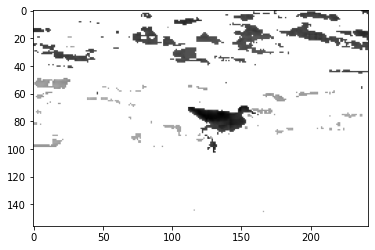

In [69]:
result = Y_target
result[s_opt] = 255
plt.imshow(result.reshape((height,width)), cmap = 'gray')

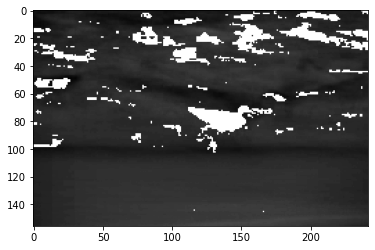

In [70]:
y_estimate = X_data[s_opt].dot(w_opt)
result = np.full(Y_target.shape,255)
result[s_opt] = y_estimate
plt.imshow(result.reshape((height,width)), cmap = 'gray')